In [11]:
from pathlib import Path

import numpy as np
import polars as pl
import lightgbm as lgb

In [12]:
path_total = Path("/home/haselab/Documents/tat/Research/app/sakana_ml/level5_pp/database.csv")

df = pl.read_csv(path_total, infer_schema_length=1000)
display(df)

# x, yともに適用する処理
# nullが10以上ある行をdrop
# df = df.with_columns(pl.Series([row.count(None) for row in df.iter_rows()]).alias("null_count")).filter(pl.col("null_count") < 10).drop("null_count")

# x, yそれぞれに適用する処理
x = df.select(df.columns[:-4])
x = x.select(~ pl.selectors.ends_with("records"))
x = x.select(~ pl.selectors.ends_with("ID"))
x = x.select(~ pl.selectors.ends_with("Scientific name"))
x = x.select(~ pl.selectors.contains("max size"))
# nullがk行を以下のカラムのみ採用
# x = x.select([col_name for col_name in x.columns if df[col_name].null_count() <=100])
x = x.select([col_name for col_name in x.columns if df[col_name].null_count() <=100 or "associate" in col_name.lower()])

# df = df.select([col_name for col_name in df.columns if df[col_name].null_count() <= 100 or (df.get_column_index(col_name) - df.width) >= -4])


ys = df.select(df.columns[-4:])
ys = ys.select(ys.columns[-3:])


# # BlankをNに置き換え
# ys = ys.with_columns(
#     pl.when(pl.all().is_null())
#     .then(pl.lit("N"))
#     .otherwise(pl.all())
#     .name.keep()
# )

# NとYを0, 1に置き換え
ys = ys.with_columns(
    pl.when(pl.all() == "N")
    .then(pl.lit(2))
    .when(pl.all() == "Y")
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .name.keep()
)

display(x)
display(ys)

# ys.write_csv("./tmp.csv")



acceptedNameUsageID,Scientific name,Depth0_Top,Depth0_Bottom,Depth0_midPoint,Depth1_Top,Depth1_Bottom,Depth1_midPoint,Lat0_Top,Lat0_Bottom,Lat0_midPoint,Lon0_Top,Lon0_Bottom,Lon0_midPoint,common size0_Top,common size0_Bottom,common size0_midPoint,max size0_Top,max size0_Bottom,max size0_midPoint,Temperature0_Top,Temperature0_Bottom,Temperature0_midPoint,Lon1_Top,Lon1_Bottom,Lon1_midPoint,max size1_Top,max size1_Bottom,max size1_midPoint,Lat1_Top,Lat1_Bottom,Lat1_midPoint,Depth2_Top,Depth2_Bottom,Depth2_midPoint,Temperature1_Top,Temperature1_Bottom,…,Salinity0_# records,TemperatureT0_Bottom,TemperatureT0_Top,TemperatureT0_Average,TemperatureT0_# records,Aggregation0_Bottom,Aggregation0_Top,Aggregation0_Average,Aggregation0_# records,Associate0_Bottom,Associate0_Top,Associate0_Average,Associate0_# records,Behavior1_Bottom,Behavior1_Top,Behavior1_Average,Behavior1_# records,Food1_Bottom,Food1_Top,Food1_Average,Food1_# records,Habitat1_Bottom,Habitat1_Top,Habitat1_Average,Habitat1_# records,Salinity1_Bottom,Salinity1_Top,Salinity1_Average,Salinity1_# records,TemperatureT1_Bottom,TemperatureT1_Top,TemperatureT1_Average,TemperatureT1_# records,ICCAT Fisheries,LL,PS,Others
i64,str,f64,f64,str,i64,i64,str,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,str,str,f64,i64,i64,str,i64,i64,str,i64,i64,…,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,str,str,str,str
105787,"""Carcharhinus a…",80.0,220.0,null,0,810,null,-31.0,46.0,null,-180.0,180.0,null,null,null,250.0,null,null,300.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1,2.0,3.0,2.5,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""",null,null
105788,"""Carcharhinus b…",0.0,200.0,null,0,100,null,-38.0,40.0,null,-100.0,155.0,null,null,null,250.0,null,null,300.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1,2.0,3.0,2.5,4,1.0,4.0,2.5,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""",null,"""Y"""
105789,"""Carcharhinus f…",0.0,500.0,null,18,500,null,-43.0,42.0,null,-180.0,180.0,null,null,null,250.0,null,null,350.0,null,null,23.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1,2.6,2.6,2.6,1,null,null,null,null,2.2,3.0,2.6,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""","""Y""","""Y"""
105790,"""Carcharhinus g…",30.0,180.0,null,0,285,null,-34.0,36.0,null,-180.0,180.0,null,null,null,300.0,null,null,370.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1,2.4,3.0,2.7,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""",null,null
105791,"""Carcharhinus i…",0.0,20.0,null,null,null,null,-38.0,42.0,null,-100.0,-12.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1,2.6,2.6,2.6,1,4.0,4.0,4.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""",null,null
105792,"""Carcharhinus l…",1.0,30.0,null,0,164,null,-39.0,42.0,null,-180.0,180.0,null,null,null,260.0,null,null,360.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,3,2.4,3.0,2.666667,3,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""","""Y""","""Y"""
105793,"""Carcharhinus l…",0.0,140.0,null,0,30,null,-38.0,45.0,null,-180.0,180.0,null,null,null,150.0,null,null,286.0,null,null,null,null,null,null,null,null,null,null,null,null,null,n

Depth0_Top,Depth0_Bottom,Lat0_Top,Lat0_Bottom,Lon0_Top,Lon0_Bottom,Behavior0_Bottom,Behavior0_Top,Behavior0_Average,Habitat0_Bottom,Habitat0_Top,Habitat0_Average,Salinity0_Bottom,Salinity0_Top,Salinity0_Average,TemperatureT0_Bottom,TemperatureT0_Top,TemperatureT0_Average,Associate0_Bottom,Associate0_Top,Associate0_Average
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
80.0,220.0,-31.0,46.0,-180.0,180.0,2.0,2.0,2.0,1.5,3.0,2.357143,2.0,2.0,2.0,2.0,3.0,2.5,null,null,null
0.0,200.0,-38.0,40.0,-100.0,155.0,3.0,3.0,3.0,1.3,2.5,1.966667,2.0,2.0,2.0,2.0,3.0,2.5,null,null,null
0.0,500.0,-43.0,42.0,-180.0,180.0,3.2,3.2,3.2,1.3,3.0,2.22,2.0,2.0,2.0,2.6,2.6,2.6,2.2,3.0,2.6
30.0,180.0,-34.0,36.0,-180.0,180.0,3.0,3.0,3.0,1.3,3.0,2.15,2.0,2.0,2.0,2.4,3.0,2.7,null,null,null
0.0,20.0,-38.0,42.0,-100.0,-12.0,1.0,1.0,1.0,1.1,2.0,1.466667,2.0,2.0,2.0,2.6,2.6,2.6,null,null,null
1.0,30.0,-39.0,42.0,-180.0,180.0,1.0,3.0,2.0,0.0,2.5,1.4,0.0,2.0,1.0,2.4,3.0,2.666667,null,null,null
0.0,140.0,-38.0,45.0,-180.0,180.0,1.0,3.0,2.0,1.0,3.0,1.86,1.0,2.0,1.5,2.4,3.0,2.666667,null,null,null
0.0,1082.0,-43.0,46.0,-180.0,180.0,3.2,3.2,3.2,2.0,3.0,2.625,2.0,2.0,2.0,2.0,3.0,2.533333,2.5,2.5,2.5
0.0,75.0,-25.0,35.0,-180.0,-134.0,null,null,null,1.0,2.5,1.525,1.0,2.0,1.5,2.6,3.0,2.8,null,null,null


LL,PS,Others
i32,i32,i32
1,0,0
1,0,1
1,1,1
1,0,0
1,0,0
1,1,1
1,0,1
1,1,1
1,0,0


In [13]:
# Using scikit-learn API
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss

# テストデータの評価
class Result:
    def __init__(self, val, proba):
        self.val = val
        self.proba = proba
        self.pred = proba.argmax(axis=1)

    def acc(self):
        return accuracy_score(self.val, self.pred)

    def f1(self):
        return f1_score(self.val, self.pred, average="macro") 

    def auc(self):
        return roc_auc_score(self.val, self.pred)
    
    def logloss(self):
        return log_loss(self.val, self.proba)

    def cm(self):
        return confusion_matrix(self.val, self.pred)

    # def acc(self):
    #     return getattr(self, "acc_tmp", self.acc_tmp := accuracy_score(self.val, self.pred))

    # def acc(self):
    #     attrname = "acc_tmp"
    #     try:
    #         return getattr(self, attrname)
    #     except:

    #         score = accuracy_score(self.val, self.pred)

    #         setattr(self, attrname, score)
    #         return getattr(self, attrname)


class Scores:
    def __init__(self):
        self.score_dict = {}
        self.cm_dict = {}
        self.proba_dict = {}
        
    def add_met(self, met_name, met_val, cm=False, proba=False):
        # if cm:
        #     ob_dict = self.cm_dict
        # elif proba:
        #     ob_dict = self.proba_dict
        # else:
        #     ob_dict = self.score_dict

        # if ob_dict.get(met_name) is None:
        #     ob_dict[met_name] = [met_val]
        # else:
        #     ob_dict[met_name].append(met_val)

        if cm:
            if self.cm_dict.get(met_name) is None:
                self.cm_dict[met_name] = [met_val]
            else:
                self.cm_dict[met_name].append(met_val)
        elif proba:
            if self.proba_dict.get(met_name) is None:
                self.proba_dict[met_name] = [met_val]
            else:
                self.proba_dict[met_name].append(met_val)
        else:
            if self.score_dict.get(met_name) is None:
                self.score_dict[met_name] = [met_val]
            else:
                self.score_dict[met_name].append(met_val)
    # def ave_met(self, met_name):
    #     met_dict = self.score_dict | self.cm_dict | self.proba_dict

    #     return met_dict[met_name]

    def ave_mets(self):
        s = Scores()
        for k, v in self.score_dict.items():
            s.add_met(k, sum(v) / len(v))
        for k, v in self.cm_dict.items():
            s.add_met(k, sum(v) / len(v), cm=True)
        for k, v in self.proba_dict.items():
            s.add_met(k, np.stack(v).mean(axis=0), proba=True)

        return s

    def fold_mets(self):
        s = Scores()
        for k, v in self.score_dict.items():
            s.add_met(k, sum(v) / len(v))
        for k, v in self.cm_dict.items():
            s.add_met(k, sum(v), cm=True)
        for k, v in self.proba_dict.items():
            s.add_met(k, np.stack(v).mean(axis=0), proba=True)

        return s

    def print_mets(self):
        met_dict = self.score_dict | self.cm_dict | self.proba_dict
        for k, v in self.met_dict.items():
            print(f"{k:8} = {v[0]}")
            
    def __or__(self, other):
        for k, v in other.score_dict.items():
            self.add_met(k, *v)
        for k, v in other.cm_dict.items():
            self.add_met(k, *v, cm=True)
        for k, v in other.proba_dict.items():
            self.add_met(k, *v, proba=True)
            
        return self


    

[[239.7  39.3]
 [ 56.1  87.9]]
[[315.65  21.35]
 [ 38.5   47.5 ]]
[[345.3  20.7]
 [ 41.8  15.2]]


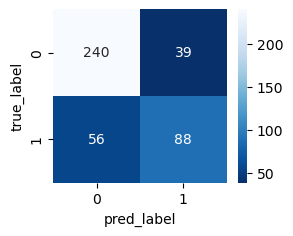

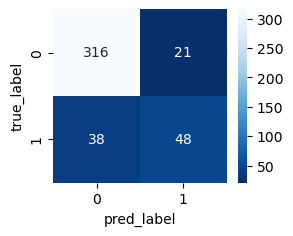

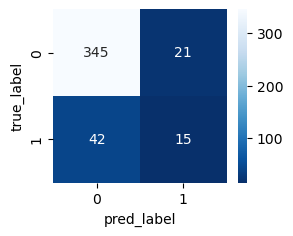

In [14]:
# Using scikit-learn API
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns


params = {
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "max_depth": 10,
    'objective': 'binary',
    "n_estimators": 100,
    "learning_rate": 0.1,

    "task": "train",
    'metric':'binary_logloss',
    'seed': 0,
    'verbosity': -1,
}

df_res_prob = None

for y in ys:

    f = Scores()
    for ri in range(20):
        kf = KFold(n_splits=4, shuffle=True, random_state=ri)
        proba = [None for i in range(len(x))]
        
        # proba管理用に一時的に
        met_dict = dict()

        s = Scores()
        for fold, (train_indices, val_indices) in enumerate(kf.split(x)):
            x_train, x_val = x[train_indices], x[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]
            
            # x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.75, random_state=0)
            # print(f"{len(x_train)=}, {len(x_val)=}")

            model = lgb.LGBMClassifier(**params)
            model.fit(x_train, y_train)

            # y_pred_tmp = model.predict(x_val)
            y_proba = model.predict_proba(x_val)
            y_pred = y_proba.argmax(axis=1)

            r = Result(y_val, y_proba)
            s.add_met("acc", r.acc())
            s.add_met("f1", r.f1())
            s.add_met("auc", r.auc())
            s.add_met("logloss", r.logloss())
            s.add_met("cm", r.cm(), cm=True)
            # s.add_met("proba", r.proba, proba=True)

            for i, idx in enumerate(val_indices):
                proba[idx] = y_proba[i]
        proba = np.stack(proba)

        if met_dict.get("proba") is None:
            met_dict["proba"] = [proba]
        else:
            met_dict["proba"].append(proba)

        f |= s.fold_mets()
    # print(model.feature_importances_)

    a = f.ave_mets()

    cm = a.cm_dict["cm"][0]
    print(cm)

    fig, ax = plt.subplots()
    fig.set_figwidth(3)
    fig.set_figheight(2.25)

    ax = sns.heatmap(cm, annot=True, cbar=True, square=True, fmt=".0f", cmap="Blues_r", xticklabels=list(range(cm.shape[0])), yticklabels=list(range(cm.shape[1])))
    ax.set_xlabel("pred_label")
    ax.set_ylabel("true_label")
    
    se_proba = pl.Series(proba[:, 1]).rename(y.name + "_prob")
    if df_res_prob is None:
        df_res_prob = se_proba.to_frame()
    else:
        df_res_prob = df_res_prob.with_columns(se_proba)
        
        
# display(df_res_prob)

df_res = df_res_prob.with_columns(
    pl.when(pl.all() < 0.5)
    .then(pl.lit("N"))
    .otherwise(pl.lit("Y"))
    .name
    .map(lambda x: x[:-5] + "_pred")
)

# display(df_pred)






acc      = 0.7966756513926325
f1       = 0.7589009536103615
logloss  = 0.566089269158435
[[247  32]
 [ 54  90]]
acc      = 0.860512129380054
f1       = 0.7570033539004484
logloss  = 0.3953002205680958
[[318  19]
 [ 40  46]]
acc      = 0.8392183288409704
f1       = 0.5898167578754938
logloss  = 0.4478429743955181
[[340  26]
 [ 42  15]]


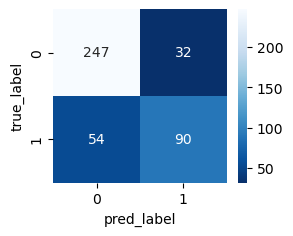

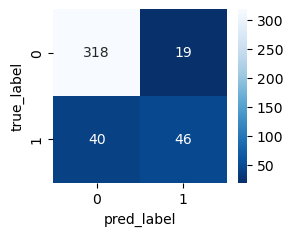

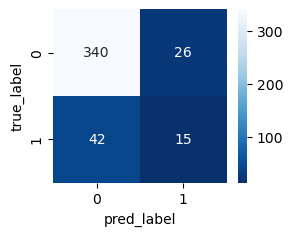

In [15]:
# Using scikit-learn API
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns


params = {
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "max_depth": 10,
    'objective': 'binary',
    "n_estimators": 100,
    "learning_rate": 0.1,

    "task": "train",
    'metric':'binary_logloss',
    'seed': 0,
    'verbosity': -1,
}

df_res_prob = None

for y in ys:

    for ri in range(2):
        kf = KFold(n_splits=4, shuffle=True, random_state=ri)
        proba = [None for i in range(len(x))]

        met_dict = dict()
        for fold, (train_indices, val_indices) in enumerate(kf.split(x)):
            x_train, x_val = x[train_indices], x[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]
            
            # x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.75, random_state=0)
            # print(f"{len(x_train)=}, {len(x_val)=}")

            model = lgb.LGBMClassifier(**params)
            model.fit(x_train, y_train)

            y_pred_tmp = model.predict(x_val)
            y_pred_proba = model.predict_proba(x_val)
            y_pred = y_pred_proba.argmax(axis=1)


            # テストデータの評価
            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average="macro")
            # auc = roc_auc_score(y_val, y_pred)
            logloss = log_loss(y_val, y_pred_proba)
            cm = confusion_matrix(y_val, y_pred)
            
            # print(model.feature_importances_)
            
            if met_dict.get("acc") is None:
                met_dict["acc"] = [acc]
            else:
                met_dict["acc"].append(acc)

            if met_dict.get("f1") is None:
                met_dict["f1"] = [f1]
            else:
                met_dict["f1"].append(f1)
            
            # if met_dict.get("auc") is None:
            #     met_dict["auc"] = [auc]
            # else:
            #     met_dict["auc"].append(auc)

            if met_dict.get("logloss") is None:
                met_dict["logloss"] = [logloss]
            else:
                met_dict["logloss"].append(logloss)

            if met_dict.get("cm") is None:
                met_dict["cm"] = [cm]
            else:
                met_dict["cm"].append(cm)

            for i, idx in enumerate(val_indices):
                proba[idx] = y_pred_proba[i]
        proba = np.stack(proba)

        if met_dict.get("proba") is None:
            met_dict["proba"] = [proba]
        else:
            met_dict["proba"].append(proba)
        
# 各統計量の平均を算出
    for k, v in met_dict.items():
        if k == "proba":
            proba = np.stack(v).mean(axis=0)
        elif k == "cm":
            cm = sum(met_dict["cm"])
            print(cm)
        else:
            print(f"{k:8} = {sum(v) / len(v)}")


    fig, ax = plt.subplots()
    fig.set_figwidth(3)
    fig.set_figheight(2.25)

    ax = sns.heatmap(cm, annot=True, cbar=True, square=True, fmt="d", cmap="Blues_r", xticklabels=list(range(cm.shape[0])), yticklabels=list(range(cm.shape[1])))
    ax.set_xlabel("pred_label")
    ax.set_ylabel("true_label")
    
    se_proba = pl.Series(proba[:, 1]).rename(y.name + "_prob")
    if df_res_prob is None:
        df_res_prob = se_proba.to_frame()
    else:
        df_res_prob = df_res_prob.with_columns(se_proba)
        
        
# display(df_res_prob)

df_res = df_res_prob.with_columns(
    pl.when(pl.all() < 0.5)
    .then(pl.lit("N"))
    .otherwise(pl.lit("Y"))
    .name
    .map(lambda x: x[:-5] + "_pred")
)

# display(df_pred)






In [16]:
df_pred = pl.concat([df, df_res], how="horizontal")

display(df_pred)
df_pred.write_csv("./prediction.csv")

acceptedNameUsageID,Scientific name,Depth0_Top,Depth0_Bottom,Depth0_midPoint,Depth1_Top,Depth1_Bottom,Depth1_midPoint,Lat0_Top,Lat0_Bottom,Lat0_midPoint,Lon0_Top,Lon0_Bottom,Lon0_midPoint,common size0_Top,common size0_Bottom,common size0_midPoint,max size0_Top,max size0_Bottom,max size0_midPoint,Temperature0_Top,Temperature0_Bottom,Temperature0_midPoint,Lon1_Top,Lon1_Bottom,Lon1_midPoint,max size1_Top,max size1_Bottom,max size1_midPoint,Lat1_Top,Lat1_Bottom,Lat1_midPoint,Depth2_Top,Depth2_Bottom,Depth2_midPoint,Temperature1_Top,Temperature1_Bottom,…,Aggregation0_Top,Aggregation0_Average,Aggregation0_# records,Associate0_Bottom,Associate0_Top,Associate0_Average,Associate0_# records,Behavior1_Bottom,Behavior1_Top,Behavior1_Average,Behavior1_# records,Food1_Bottom,Food1_Top,Food1_Average,Food1_# records,Habitat1_Bottom,Habitat1_Top,Habitat1_Average,Habitat1_# records,Salinity1_Bottom,Salinity1_Top,Salinity1_Average,Salinity1_# records,TemperatureT1_Bottom,TemperatureT1_Top,TemperatureT1_Average,TemperatureT1_# records,ICCAT Fisheries,LL,PS,Others,LL_prob,PS_prob,Others_prob,LL_pred,PS_pred,Others_pred
i64,str,f64,f64,str,i64,i64,str,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,str,str,f64,i64,i64,str,i64,i64,str,i64,i64,…,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,i64,str,str,str,str,f64,f64,f64,str,str,str
105787,"""Carcharhinus a…",80.0,220.0,null,0,810,null,-31.0,46.0,null,-180.0,180.0,null,null,null,250.0,null,null,300.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""",null,null,0.285496,0.164342,0.069292,"""N""","""N""","""N"""
105788,"""Carcharhinus b…",0.0,200.0,null,0,100,null,-38.0,40.0,null,-100.0,155.0,null,null,null,250.0,null,null,300.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,4.0,2.5,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""",null,"""Y""",0.770749,0.13857,0.140581,"""Y""","""N""","""N"""
105789,"""Carcharhinus f…",0.0,500.0,null,18,500,null,-43.0,42.0,null,-180.0,180.0,null,null,null,250.0,null,null,350.0,null,null,23.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,2.2,3.0,2.6,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""","""Y""","""Y""",0.867466,0.947888,0.056758,"""Y""","""Y""","""N"""
105790,"""Carcharhinus g…",30.0,180.0,null,0,285,null,-34.0,36.0,null,-180.0,180.0,null,null,null,300.0,null,null,370.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""",null,null,0.223272,0.594603,0.024331,"""N""","""Y""","""N"""
105791,"""Carcharhinus i…",0.0,20.0,null,null,null,null,-38.0,42.0,null,-100.0,-12.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,4.0,4.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""",null,null,0.821822,0.050827,0.002406,"""Y""","""N""","""N"""
105792,"""Carcharhinus l…",1.0,30.0,null,0,164,null,-39.0,42.0,null,-180.0,180.0,null,null,null,260.0,null,null,360.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Y""","""Y""","""Y""","""Y""",0.538672,0.402663,0.081317,"""Y""","""N""","""N"""
105793,"""Carcharhinus l…",0.0,140.0,null,0,30,null,-38.0,45.0,null,-180.0,18